# Hyperparameter Tuning Deep Learning (LSTM and GRU)

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 8.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 7.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [scipy]
      Successfully uninstalled scipy-1.15.2━━━━━━━━━━━━━━━━━━━ 1/3 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]


## 1. Import package and data

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import KeyedVectors

# Step 1: Data loading & preprocessing
df = pd.read_csv("../dataset/cleaned_dataset_deeplearning_lstm_gru_model.csv")

## 2. Tokenization & Encoding

In [4]:
# Step 2: Tokenization & Encoding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X = pad_sequences(sequences, maxlen=50)

In [5]:
X

array([[   0,    0,    0, ..., 3010,   31,   73],
       [   0,    0,    0, ..., 3013, 2018, 3014],
       [   0,    0,    0, ..., 1285,  115, 3015],
       ...,
       [   0,    0,    0, ...,    5,  494,   45],
       [   0,    0,    0, ...,    8,    5,  769],
       [   0,    0,    0, ...,    3, 1797, 3005]], dtype=int32)

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['sentimen'])
y

array([0, 1, 1, ..., 1, 1, 1])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 3. Load FastText Embedding

In [8]:
# Step 3: Load FastText embedding
print("⏳ Loading FastText...")
fasttext_model = KeyedVectors.load_word2vec_format("../pretrained/cc.id.300.vec") #cc.id.300.vec")

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

⏳ Loading FastText...


In [13]:
embedding_matrix

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0025, -0.0087,  0.0529, ..., -0.0199,  0.0057,  0.0226],
       ...,
       [ 0.018 , -0.0158,  0.0075, ...,  0.0016, -0.0549,  0.0211],
       [ 0.0126,  0.0124, -0.0052, ..., -0.0702, -0.0078,  0.0154],
       [ 0.028 ,  0.0044, -0.0025, ..., -0.0359,  0.0236, -0.0019]])

## 4. Train & Tune Models

In [14]:
# Step 4: Train & tune models
def build_model(model_type="lstm", units=64, dropout=0.5, save_path="best_model.h5"):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=50,
                        trainable=False))
    if model_type == "lstm":
        model.add(LSTM(units))
    else:
        model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True)
    ]
    
    return model, callbacks



In [15]:
# Step 5: Train LSTM & GRU
print("🚀 Training LSTM with FastText...")
model_lstm, cb_lstm = build_model("lstm", 64, 0.5, "../models/best_lstm_model.h5")
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test),
                              epochs=15, batch_size=32, callbacks=cb_lstm, verbose=1)

🚀 Training LSTM with FastText...


/Users/macbook/anaconda3/envs/sentiment-analysis-nlp/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3682 - loss: 1.0862

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3706 - loss: 1.0852 - val_accuracy: 0.4766 - val_loss: 1.0170
Epoch 2/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5119 - loss: 0.9952

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5121 - loss: 0.9946 - val_accuracy: 0.5234 - val_loss: 0.9977
Epoch 3/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5667 - loss: 0.9416

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5669 - loss: 0.9408 - val_accuracy: 0.5675 - val_loss: 0.9286
Epoch 4/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6067 - loss: 0.8875

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6067 - loss: 0.8870 - val_accuracy: 0.5923 - val_loss: 0.8939
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6276 - loss: 0.8372 - val_accuracy: 0.5702 - val_loss: 0.9286
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6200 - loss: 0.8701 - val_accuracy: 0.5565 - val_loss: 0.9154
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6357 - loss: 0.8168 - val_accuracy: 0.5895 - val_loss: 0.8914
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6417 - loss: 0.7864

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6418 - loss: 0.7863 - val_accuracy: 0.5978 - val_loss: 0.8893
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6734 - loss: 0.7501 - val_accuracy: 0.5868 - val_loss: 0.9193
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6761 - loss: 0.7358 - val_accuracy: 0.5813 - val_loss: 0.9035
Epoch 11/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7088 - loss: 0.6959

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7082 - loss: 0.6965 - val_accuracy: 0.6006 - val_loss: 0.9339


In [16]:
print("🚀 Training GRU with FastText...")
model_gru, cb_gru = build_model("gru", 64, 0.5, "../models/best_gru_model.h5")
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=15, batch_size=32, callbacks=cb_gru, verbose=1)


🚀 Training GRU with FastText...
Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3877 - loss: 1.0867

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.3886 - loss: 1.0865 - val_accuracy: 0.5069 - val_loss: 1.0571
Epoch 2/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5058 - loss: 1.0201

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5063 - loss: 1.0190 - val_accuracy: 0.5289 - val_loss: 0.9775
Epoch 3/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5705 - loss: 0.9231

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5706 - loss: 0.9231 - val_accuracy: 0.5813 - val_loss: 0.9368
Epoch 4/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6264 - loss: 0.8738

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6256 - loss: 0.8744 - val_accuracy: 0.5868 - val_loss: 0.9444
Epoch 5/15
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6354 - loss: 0.8484

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6351 - loss: 0.8475 - val_accuracy: 0.6116 - val_loss: 0.9303
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6343 - loss: 0.8200 - val_accuracy: 0.5730 - val_loss: 0.9161
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6518 - loss: 0.8016 - val_accuracy: 0.5923 - val_loss: 0.9052
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6957 - loss: 0.7371 - val_accuracy: 0.5730 - val_loss: 0.9165
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6755 - loss: 0.7440

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6756 - loss: 0.7438 - val_accuracy: 0.6198 - val_loss: 0.9022
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7146 - loss: 0.7134 - val_accuracy: 0.6033 - val_loss: 0.8916
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6907 - loss: 0.7190 - val_accuracy: 0.6006 - val_loss: 0.8909
Epoch 12/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7096 - loss: 0.6833 - val_accuracy: 0.5950 - val_loss: 0.9035
Epoch 13/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7269 - loss: 0.6525 - val_accuracy: 0.5868 - val_loss: 0.9673
Epoch 14/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7247 - loss: 0.6567 - val_accuracy: 0.6033 - val_loss: 0.9368


## 5. Visualisasi Learning Process

In [17]:
def plot_learning(history, model_name):
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

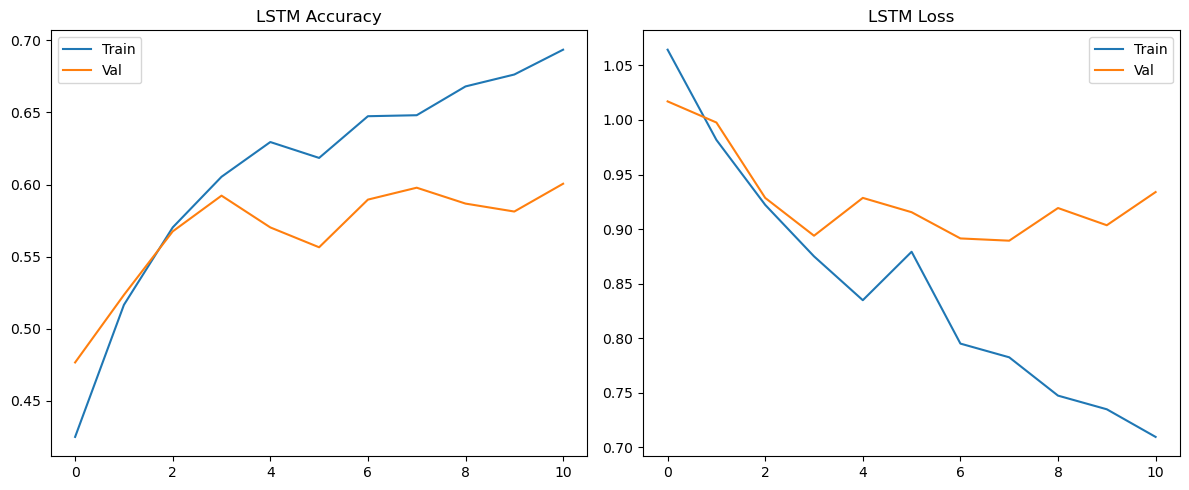

In [18]:
plot_learning(history_lstm, "LSTM")

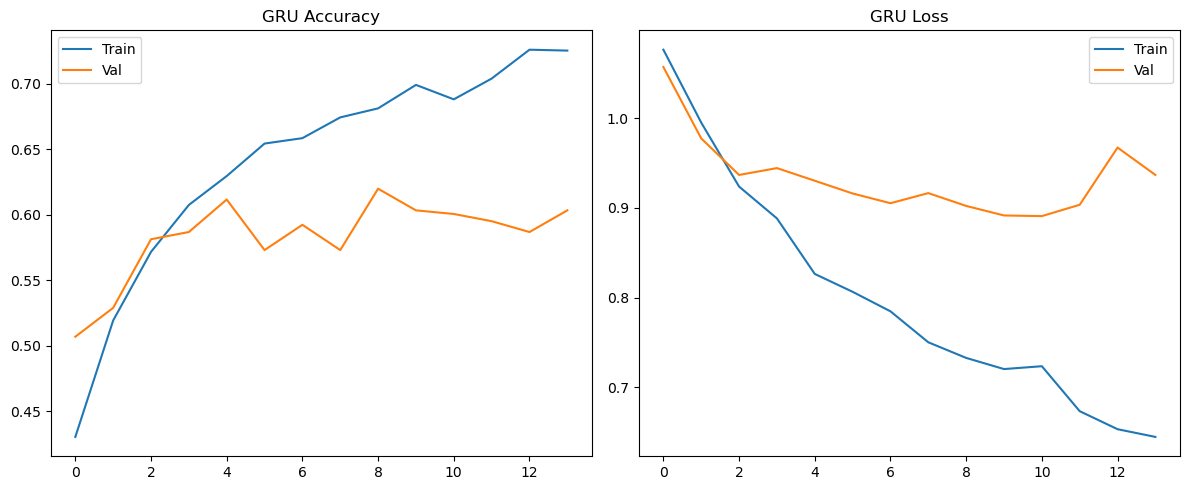

In [19]:
plot_learning(history_gru, "GRU")

## 6. Visualisasi Performa Model (Bar Chart)

/var/folders/kb/msyd5l4n7xj0yh064xpqdg400000gn/T/ipykernel_15021/2152225.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(val_accs.keys()), y=list(val_accs.values()), palette='pastel')


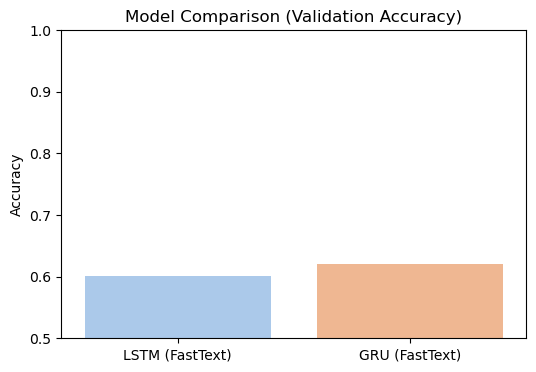

In [20]:
val_accs = {
    "LSTM (FastText)": max(history_lstm.history['val_accuracy']),
    "GRU (FastText)": max(history_gru.history['val_accuracy']),
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(val_accs.keys()), y=list(val_accs.values()), palette='pastel')
plt.title("Model Comparison (Validation Accuracy)")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.show()


In [32]:
import joblib
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

class KerasSentimentModel:
    def __init__(self, model, tokenizer, label_encoder):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def predict(self, texts):
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=50)
        preds = self.model.predict(padded)
        labels = np.argmax(preds, axis=1)
        return self.label_encoder.inverse_transform(labels)

# Simpan wrapper LSTM
wrapped_lstm = KerasSentimentModel(model_lstm, tokenizer, le)
joblib.dump(wrapped_lstm, "../models/lstm_sentiment_model.pkl")

# Simpan wrapper GRU
wrapped_gru = KerasSentimentModel(model_gru, tokenizer, le)
joblib.dump(wrapped_gru, "../models/gru_sentiment_model.pkl")


['../models/gru_sentiment_model.pkl']

In [33]:
model_lstm_loaded = joblib.load("../models/lstm_sentiment_model.pkl")
model_gru_loaded = joblib.load("../models/gru_sentiment_model.pkl")

/Users/macbook/anaconda3/envs/sentiment-analysis-nlp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
print(model_lstm_loaded.predict(["Saya sangat kecewa dengan janji politik."]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['netral']


In [37]:
print(model_gru_loaded.predict(["Saya sangat kecewa dengan janji politik."]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
['netral']


In [ ]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ⚙️ Class Wrapper
class KerasSentimentModel:
    def __init__(self, model, tokenizer, label_encoder, max_len=50):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.max_len = max_len

    def predict(self, texts):
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len)
        probs = self.model.predict(padded)
        preds = np.argmax(probs, axis=1)
        return self.label_encoder.inverse_transform(preds)

# 📦 Load model yang sudah disimpan dari training terbaik
model_lstm = load_model("../models/best_lstm_model.h5")
model_gru = load_model("../models/best_gru_model.h5")

# 📦 Load tokenizer dan label encoder dari training (pastikan kamu simpan mereka sebelumnya)
import pickle
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# ✅ Bungkus ke dalam class
wrapped_lstm = KerasSentimentModel(model_lstm, tokenizer, le)
wrapped_gru = KerasSentimentModel(model_gru, tokenizer, le)

# 💾 Simpan ke .pkl
joblib.dump(wrapped_lstm, "../models/lstm_sentiment_model.pkl")
joblib.dump(wrapped_gru, "../models/gru_sentiment_model.pkl")
